# Coding Implementation of Traffic Sign Classifier  

In [2]:
# import library files
import os
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline
#%pylab inline

In [3]:
# Load pickled data
training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


In [4]:
sign_names = pd.read_csv("signnames.csv", index_col=0)
sign_names

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [5]:
sign_names = np.array(sign_names)


In [6]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


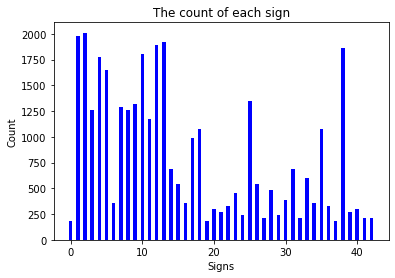

In [7]:
## Graph showing the count of each classes 
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='b')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.savefig("Count of each sign")


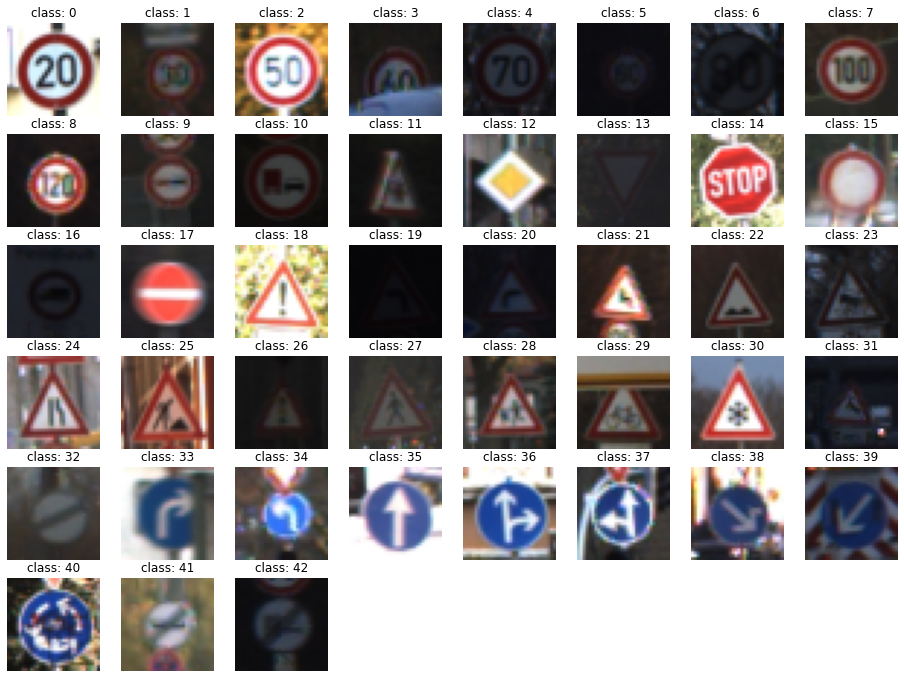

In [8]:
# Images from each class 
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')    
    plt.title('class: {}'.format(c))
    plt.xlabel("class")
    plt.imshow(X_train[i])
plt.savefig("Image of each sign")

In [9]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

In [10]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [11]:
class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
torch.manual_seed(1)

In [13]:
#Convert the dataset to tensor form 
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [14]:
# Train the model on GPU if available 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_loader = WrappedDataLoader(train_loader, to_device)
valid_loader = WrappedDataLoader(valid_loader, to_device)
test_loader = WrappedDataLoader(test_loader, to_device)

In [15]:
model = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20

In [16]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

In [17]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)

In [18]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    t_l =[]
    v_l=[]
    for epoch in range(epochs):
        # Train model
        
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        t_l.append(train_loss)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            v_l.append(valid_loss)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
    return v_l,t_l

In [19]:
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [20]:
result = fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.675417	Validation loss: 3.591743	 Validation accruacy: 5.578%
[Epoch 2/20] Train loss: 3.484753	Validation loss: 3.570508	 Validation accruacy: 6.553%
[Epoch 3/20] Train loss: 3.457674	Validation loss: 3.540419	 Validation accruacy: 7.052%
[Epoch 4/20] Train loss: 3.341505	Validation loss: 3.352471	 Validation accruacy: 17.075%
[Epoch 5/20] Train loss: 2.718756	Validation loss: 2.373314	 Validation accruacy: 37.234%
[Epoch 6/20] Train loss: 1.724413	Validation loss: 1.639816	 Validation accruacy: 53.197%
[Epoch 7/20] Train loss: 1.149941	Validation loss: 1.171707	 Validation accruacy: 66.735%
[Epoch 8/20] Train loss: 0.859912	Validation loss: 0.970216	 Validation accruacy: 72.630%
[Epoch 9/20] Train loss: 0.681410	Validation loss: 0.952476	 Validation accruacy: 72.608%
[Epoch 10/20] Train loss: 0.564549	Validation loss: 0.813672	 Validation accruacy: 77.596%
[Epoch 11/20] Train loss: 0.477375	Validation loss: 0.735447	 Validation accruacy: 79.615%
[Epoch 12/2

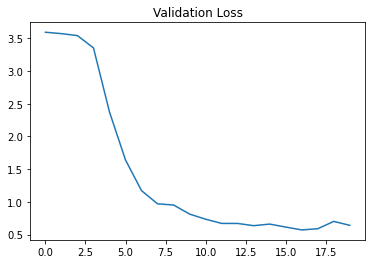

In [21]:
x1_vl= [i for i in range(n_epochs)]
y1_vl = result[0]
plt.plot(x1_vl,y1_vl)
plt.title("Validation Loss")
plt.show()
#plt.savefig("Validation Loss")

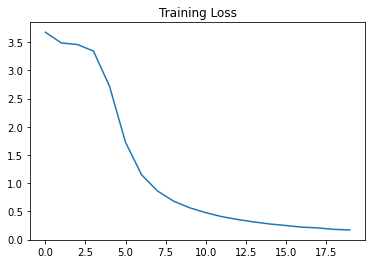

In [22]:
x1_tl= [i for i in range(n_epochs)]
y1_tl = result[1]
plt.plot(x1_tl,y1_tl)
plt.title("Training Loss")
plt.show()
#plt.savefig("Training Loss")

## preprocessing (convert to grayscale)

In [23]:
class CLAHE_GRAY:
    def __init__(self, clipLimit=2.5, tileGridSize=(4, 4)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_y = clahe.apply(img_y)
        img_output = img_y.reshape(img_y.shape + (1,))
        return img_output

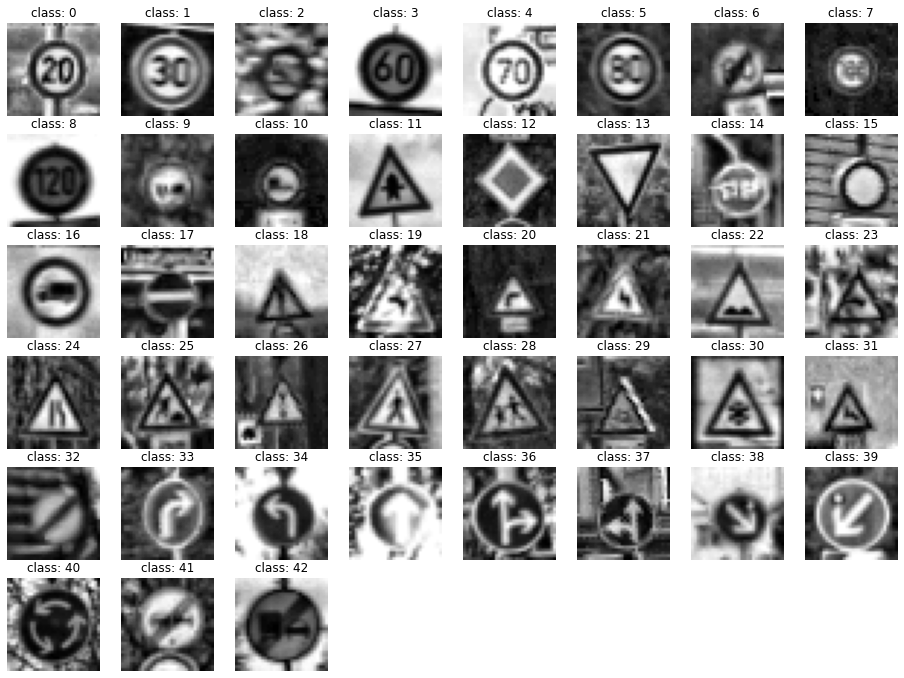

In [24]:
clahe = CLAHE_GRAY()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')
    plt.savefig("Gray dataset")

In [25]:
data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor()
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

In [26]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
result2=fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.727781	Validation loss: 3.685298	 Validation accruacy: 5.442%
[Epoch 2/20] Train loss: 3.526098	Validation loss: 3.554974	 Validation accruacy: 5.442%
[Epoch 3/20] Train loss: 3.442328	Validation loss: 3.492643	 Validation accruacy: 14.467%
[Epoch 4/20] Train loss: 3.124731	Validation loss: 2.769499	 Validation accruacy: 28.209%
[Epoch 5/20] Train loss: 1.980560	Validation loss: 1.632423	 Validation accruacy: 54.263%
[Epoch 6/20] Train loss: 1.197896	Validation loss: 1.077256	 Validation accruacy: 68.821%
[Epoch 7/20] Train loss: 0.837146	Validation loss: 0.816877	 Validation accruacy: 74.853%
[Epoch 8/20] Train loss: 0.646932	Validation loss: 0.698551	 Validation accruacy: 78.798%
[Epoch 9/20] Train loss: 0.530533	Validation loss: 0.634674	 Validation accruacy: 79.683%
[Epoch 10/20] Train loss: 0.443689	Validation loss: 0.584969	 Validation accruacy: 82.109%
[Epoch 11/20] Train loss: 0.382907	Validation loss: 0.491439	 Validation accruacy: 85.261%
[Epoch 12/

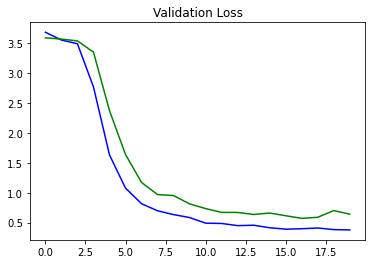

In [27]:
x2_vl= [i for i in range(n_epochs)]
y2_vl = result2[0]
plt.plot(x2_vl,y2_vl,'b')
plt.plot(x1_vl,y1_vl,'g')
plt.title("Validation Loss")
plt.show()
#plt.savefig("Validation Loss")

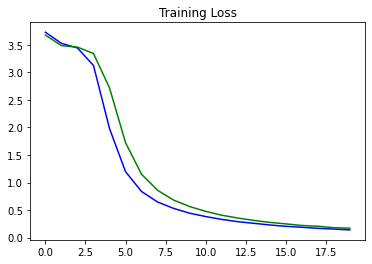

In [28]:
x2_tl= [i for i in range(n_epochs)]
y2_tl = result2[1]
plt.plot(x2_tl,y2_tl,'b')
plt.plot(x1_tl,y1_tl,'g')
plt.title("Training Loss")
plt.show()
#plt.savefig("Training Loss")

## Saving the pre-processed image 

In [29]:
def preprocess(path):
    if not os.path.exists(f"{path}/train_gray.p"):
        for dataset in ['train', 'valid', 'test']:
            with open(f"{path}/{dataset}.p", mode='rb') as f:
                data = pickle.load(f)
                X = data['features']
                y = data['labels']

            clahe = CLAHE_GRAY()
            for i in range(len(X)):
                X[i] = clahe(X[i])

            X = X[:, :, :, 0]
            with open(f"{path}/{dataset}_gray.p", "wb") as f:
                pickle.dump({"features": X.reshape(
                    X.shape + (1,)), "labels": y}, f)

In [30]:
preprocess('data')
training_file = 'data/train_gray.p'
validation_file = "data/valid_gray.p"
testing_file = "data/test_gray.p"

In [31]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

## Flipping

In [32]:
def extend_dataset(dataset):
    X = dataset.features
    y = dataset.labels
    num_classes = 43
    
    X_extended = np.empty([0] + list(dataset.features.shape)[1:], dtype=dataset.features.dtype)
    y_extended = np.empty([0], dtype = dataset.labels.dtype)
    
    horizontally_flippable = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    vertically_flippable = [1, 5, 12, 15, 17]
    both_flippable = [32, 40]
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38]
    ])
    
    for c in range(num_classes):
        X_extended = np.append(X_extended, X[y==c], axis=0)  
        
        if c in horizontally_flippable:
            X_extended = np.append(X_extended, X[y==c][:,:,::-1,:], axis=0)
        if c in vertically_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,:,:], axis=0)
        if c in cross_flippable[:,0]:
            flip_c = cross_flippable[cross_flippable[:,0]==c][0][1]
            X_extended = np.append(X_extended, X[y==flip_c][:,:,::-1,:], axis=0)
        if c in both_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,::-1,:], axis=0)
        
        y_extended = np.append(y_extended, np.full(X_extended.shape[0]-y_extended.shape[0], c, dtype=y_extended.dtype))
    
    dataset.features = X_extended
    dataset.labels = y_extended
    dataset.count = len(y_extended)
    
    return dataset

In [33]:
train_dataset = extend_dataset(train_dataset)
train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)

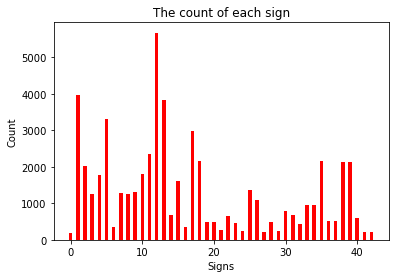

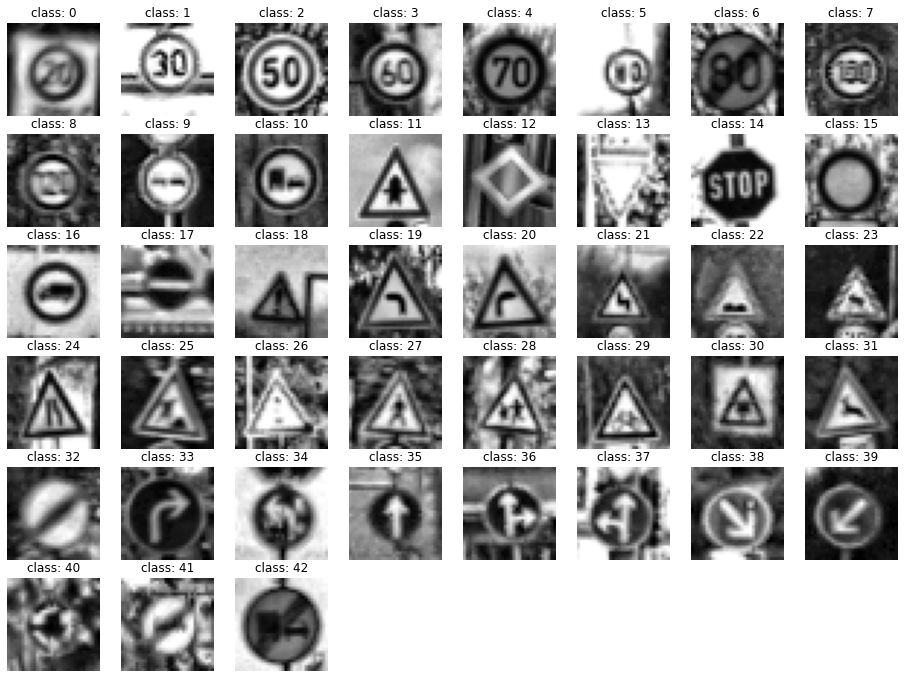

In [34]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(train_dataset.labels), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(train_dataset.labels == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(train_dataset.features[i].squeeze(), cmap='gray')
    plt.savefig("flipping dataset")

In [35]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
result3 = fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.606451	Validation loss: 3.639088	 Validation accruacy: 4.762%
[Epoch 2/20] Train loss: 3.379275	Validation loss: 3.596407	 Validation accruacy: 6.825%
[Epoch 3/20] Train loss: 2.673853	Validation loss: 2.139009	 Validation accruacy: 38.186%
[Epoch 4/20] Train loss: 1.280364	Validation loss: 1.258234	 Validation accruacy: 62.109%
[Epoch 5/20] Train loss: 0.819816	Validation loss: 0.949757	 Validation accruacy: 71.247%
[Epoch 6/20] Train loss: 0.616574	Validation loss: 0.727809	 Validation accruacy: 79.093%
[Epoch 7/20] Train loss: 0.486329	Validation loss: 0.605616	 Validation accruacy: 82.789%
[Epoch 8/20] Train loss: 0.399065	Validation loss: 0.594906	 Validation accruacy: 82.381%
[Epoch 9/20] Train loss: 0.333335	Validation loss: 0.512264	 Validation accruacy: 85.306%
[Epoch 10/20] Train loss: 0.283837	Validation loss: 0.472246	 Validation accruacy: 86.009%
[Epoch 11/20] Train loss: 0.247025	Validation loss: 0.458494	 Validation accruacy: 86.803%
[Epoch 12/

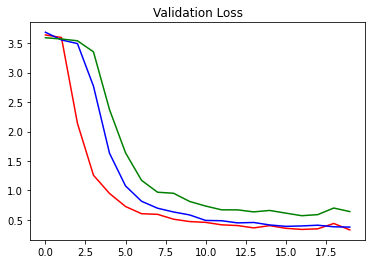

In [36]:
x3_vl= [i for i in range(n_epochs)]
y3_vl = result3[0]
plt.plot(x3_vl,y3_vl,'r')
plt.plot(x2_vl,y2_vl,'b')
plt.plot(x1_vl,y1_vl,'g')
plt.title("Validation Loss")
plt.show()
#plt.savefig("Validation Loss")

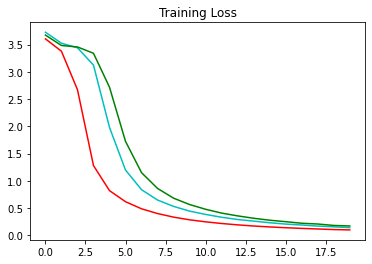

In [37]:
x3_tl= [i for i in range(n_epochs)]
y3_tl = result3[1]
plt.plot(x3_tl,y3_tl,'r')
plt.plot(x2_tl,y2_tl,'c')
plt.plot(x1_tl,y1_tl,'g')
plt.title("Training Loss")
plt.show()
#plt.savefig("Training Loss")

## Data augmentation

In [38]:
train_dataset = extend_dataset(PickledDataset(training_file))

class_sample_count = np.bincount(train_dataset.labels)
weights = 1 / np.array([class_sample_count[y] for y in train_dataset.labels])
samp = sampler.WeightedRandomSampler(weights, 43 * 20000)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)

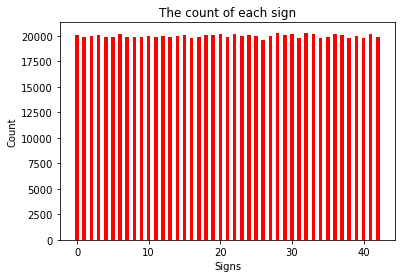

In [39]:
balanced_y_train = torch.LongTensor([]).to(device)

with torch.no_grad():
    for _, y in train_loader:
        balanced_y_train = torch.cat((balanced_y_train, y))

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balanced_y_train.cpu().numpy()), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

In [40]:
train_data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
    ]),
    transforms.ToTensor()
])
test_data_transforms = transforms.ToTensor()

train_dataset = extend_dataset(PickledDataset(training_file, transform=train_data_transforms))
valid_dataset = PickledDataset(validation_file, transform=test_data_transforms)
test_dataset = PickledDataset(testing_file, transform=test_data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

In [41]:
def convert_image_np(img):
    img = img.numpy().transpose((1, 2, 0)).squeeze()
    return img

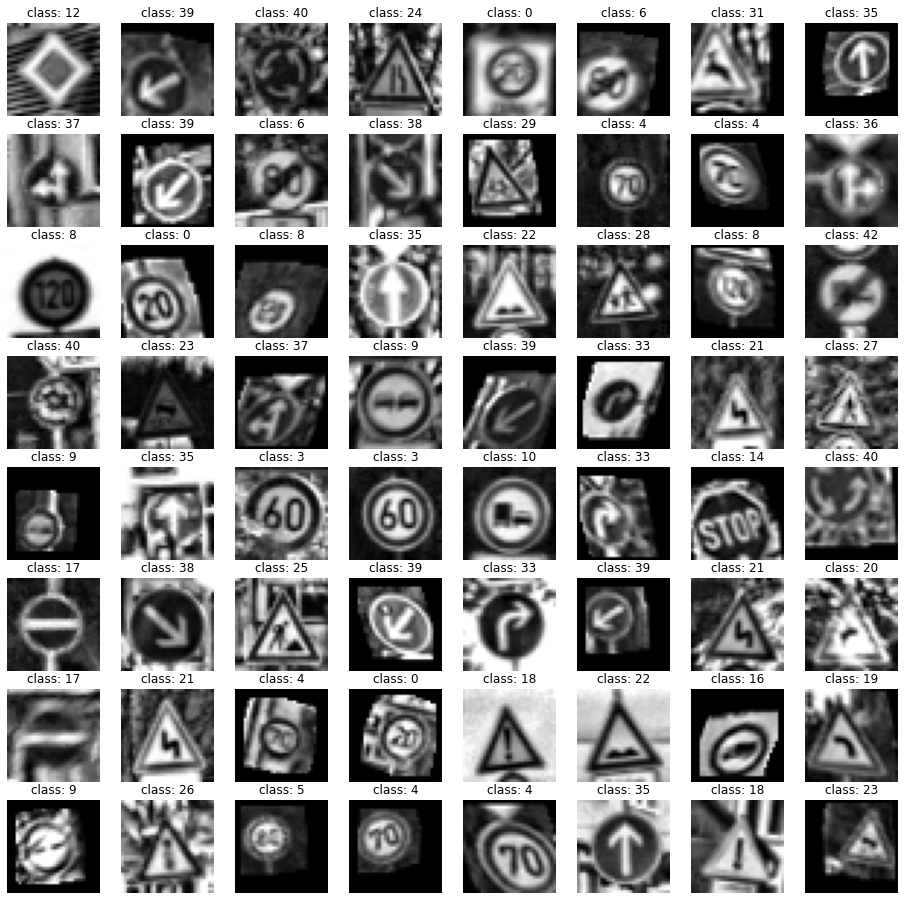

In [42]:
with torch.no_grad():
    x, y = next(iter(train_loader))
    plt.figure(figsize=(16, 16))
    for i in range(len(y)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('class: {}'.format(y[i]))
        plt.imshow(convert_image_np(x[i].cpu()), cmap='gray')
        plt.savefig("data after augmentation")

In [43]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
result4 = fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 2.389225	Validation loss: 0.583152	 Validation accruacy: 82.630%
[Epoch 2/20] Train loss: 0.774484	Validation loss: 0.357066	 Validation accruacy: 90.363%
[Epoch 3/20] Train loss: 0.513626	Validation loss: 0.356082	 Validation accruacy: 90.975%
[Epoch 4/20] Train loss: 0.410391	Validation loss: 0.315006	 Validation accruacy: 92.789%
[Epoch 5/20] Train loss: 0.349123	Validation loss: 0.306423	 Validation accruacy: 92.676%
[Epoch 6/20] Train loss: 0.308288	Validation loss: 0.295984	 Validation accruacy: 93.719%
[Epoch 7/20] Train loss: 0.276010	Validation loss: 0.308181	 Validation accruacy: 93.923%
[Epoch 8/20] Train loss: 0.251985	Validation loss: 0.238012	 Validation accruacy: 94.671%
[Epoch 9/20] Train loss: 0.231204	Validation loss: 0.251672	 Validation accruacy: 94.014%
[Epoch 10/20] Train loss: 0.216938	Validation loss: 0.253943	 Validation accruacy: 94.354%
[Epoch 11/20] Train loss: 0.203654	Validation loss: 0.215723	 Validation accruacy: 94.875%
[Epoch 1

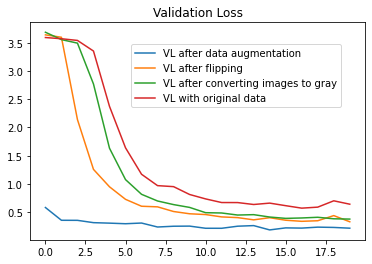

In [44]:
x4_vl= [i for i in range(n_epochs)]
y4_vl = result4[0]
plt.plot(x4_vl,y4_vl,label = "VL after data augmentation")
plt.plot(x3_vl,y3_vl,label = "VL after flipping")
plt.plot(x2_vl,y2_vl,label = "VL after converting images to gray")
plt.plot(x1_vl,y1_vl,label = "VL with original data")
plt.title("Validation Loss")
plt.legend(bbox_to_anchor=(0.3, 0.9), loc='upper left', borderaxespad=0.)
plt.show()
#plt.savefig("Validation Loss pr2")

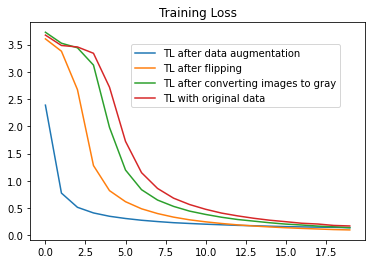

In [52]:
x4_tl= [i for i in range(n_epochs)]
y4_tl = result4[1]
plt.plot(x4_tl,y4_tl,label = "TL after data augmentation")
plt.plot(x3_tl,y3_tl,label = "TL after flipping")
plt.plot(x2_tl,y2_tl,label = "TL after converting images to gray")
plt.plot(x1_tl,y1_tl,label = "TL with original data")
plt.title("Training Loss")
plt.legend(bbox_to_anchor=(0.3, 0.9), loc='upper left', borderaxespad=0.)
plt.show()
#plt.savefig("Training Loss pr2")

# Results and visulaization

In [46]:
test_loader

In [47]:
x, y = next(iter(test_loader))

In [48]:
o = model(x)
loss = criterion(o, y)
#loss
pred = torch.argmax(o, dim=1)

#correct
print(pred[0].numpy())
correct = pred == y.view(*pred.shape)
correct

16


tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True])

Actual Sign: ['Slippery road']
Predicted Sign:['Slippery road']


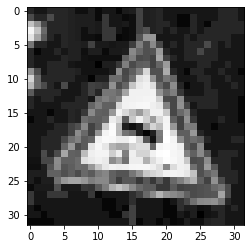

In [49]:
plt.imshow(x[12].numpy().transpose((1, 2, 0)).squeeze(), cmap='Greys_r');
print('Actual Sign: {0}'.format(sign_names[y[12]]))
print('Predicted Sign:{0}'.format(sign_names[pred[12].numpy()]))

Actual Sign: ['Speed limit (30km/h)']
Predicted Sign:['Speed limit (30km/h)']


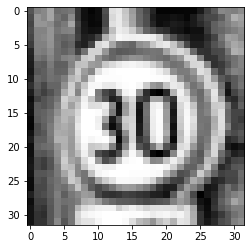

In [50]:
plt.imshow(x[1].numpy().transpose((1, 2, 0)).squeeze(), cmap='Greys_r');
print('Actual Sign: {0}'.format(sign_names[y[1]]))
print('Predicted Sign:{0}'.format(sign_names[pred[1].numpy()]))

Actual Sign: ['Pedestrians']
Predicted Sign:['Pedestrians']


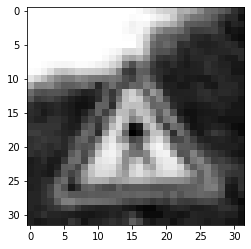

In [51]:
plt.imshow(x[18].numpy().transpose((1, 2, 0)).squeeze(), cmap='Greys_r');
print('Actual Sign: {0}'.format(sign_names[y[18]]))
print('Predicted Sign:{0}'.format(sign_names[pred[18].numpy()]))
